# **Intro**
In this notebook I set up semi-supervised VAE that attempts to predict the digit from MNIST numbers.
In this vanilla semi-supervised VAE (ssVAE), we use the digits as labels.
We omit some labels so that it is semi-supervised.
Also, we use the M2 formulation of semi-supervised as described here: "Semi-supervised Learning with Deep Generative Models", https://arxiv.org/abs/1406.5298

A lot of the model code was taken from this tutorial: https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb

And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning 
with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/






# **Imports**

In [1]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score



# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

# programming stuff
import time
import os
import pickle
from pathlib import Path

# Load the TensorBoard notebook extension
%load_ext tensorboard

# I disable eager execution 
# # https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# **Import and Pre-process data**
Import + reshape the MNIST data

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

print("\nfirst 5 elements of y_train\n")
print(y_train[0:5])

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)

first 5 elements of y_train

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# **Model Definition**

## Hyperparameters


In [3]:
batch_size = 100
n_epoch = 10

# 28*28 = 784
# the network dimensions are 784 > 512 > 10 < 512 < 784
n_z = 10 # latent space size, one latent dimension PER MNIST digit
encoder_dim = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of decoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer

activ = 'relu'
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005) #0.001

n_x = X_train.shape[1]
n_y = y_train.shape[1]

print(f"length of X {n_x} and length of y {n_y}")



length of X 784 and length of y 10


## Encoder

In [4]:
# declare the Keras tensor we will use as input to the encoder
_X = Input(batch_shape=(batch_size, n_x))
_Y = Input(batch_shape=(batch_size, n_y))

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_h = Dense(encoder_dim, activation=activ, name="encoder_1")(_X)

# now from the hidden layer, you get the mu and sigma for 
# the latent space
mu = Dense(n_z, activation='linear', name = "mu")(encoder_h)
l_sigma = Dense(n_z, activation='linear', name = "sigma")(encoder_h)



## Latent Space + Classifier

Classifier uses z to do prediction.
This is great when we have limited labeled data, because we can get a good representation to train the classifier on.

In [5]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

def null_f(args):
    return args

# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ), name="z_samp")([mu, l_sigma])
#z_l = Lambda(null_f, output_shape = (n_z, ), name="z_null")(z)

#defining the architecture of the classifier
class_hidden1 = Dense(n_z, activation=activ, name = "cls_h1")
class_out = Dense(n_z, activation='softmax', name="cls_out")

classifier_h1 = class_hidden1(z) #z_l
_Y_cls = class_out(classifier_h1)


# again, this is kind of conditional, since we are using
# the classifier labels.... 
# we merge latent space with label or the predicted label
zc_labeled = concat([z, _Y])

zc_unlabeled = concat([z, _Y_cls])


## Decoder




In [6]:
# set up decoder network
decoder_hidden = Dense(decoder_dim, activation=activ, name = "decoder_h1")
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out")


# this is the LABELED decoder
d_h1_lab = decoder_hidden(z)
d_out_lab = decoder_out(d_h1_lab)


# this is the UNlabeled decoder
d_h1_unlab = decoder_hidden(z)
d_out_unlab = decoder_out(d_h1_unlab)


## Loss

In [7]:
beta = 1
def labeled_vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = beta * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def unlabeled_vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = beta * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)

    return recon + kl

def KL_loss(y_true, y_pred):
	return(beta * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

def cls_loss(y_true, y_pred, N=1000):
    return K.categorical_crossentropy(y_true, y_pred)*1000


## Make the computational graph

In [8]:
ss_vae_lab = Model([_X, _Y], [d_out_lab, _Y_cls])

ss_vae_unlab = Model(_X, d_out_unlab)

classifier = Model(_X, _Y_cls)

ss_vae_lab.compile(optimizer=optim, loss=[labeled_vae_loss, cls_loss]) #, metrics = [KL_loss, recon_loss])
ss_vae_unlab.compile(optimizer=optim, loss=unlabeled_vae_loss) #, metrics = [KL_loss, recon_loss])

ss_vae_lab_init_wts = ss_vae_lab.get_weights()
ss_vae_unlab_init_wts = ss_vae_unlab.get_weights()
classifier_init_wts = classifier.get_weights()


print(ss_vae_lab.summary())
print(ss_vae_unlab.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(100, 784)]         0           []                               
                                                                                                  
 encoder_1 (Dense)              (100, 512)           401920      ['input_1[0][0]']                
                                                                                                  
 mu (Dense)                     (100, 10)            5130        ['encoder_1[0][0]']              
                                                                                                  
 sigma (Dense)                  (100, 10)            5130        ['encoder_1[0][0]']              
                                                                                              

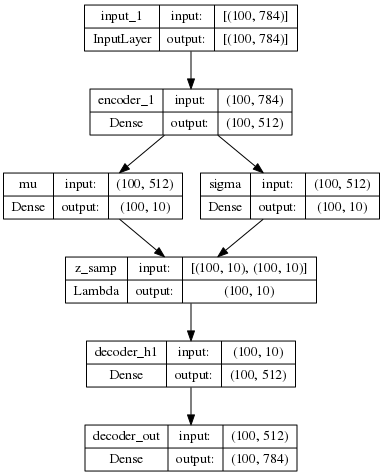

In [9]:
display(plot_model(ss_vae_unlab, show_layer_names=True, show_shapes=True, dpi=72))

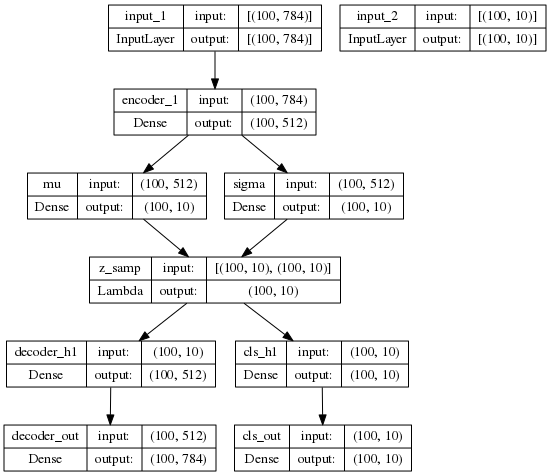

In [10]:
display(plot_model(ss_vae_lab, show_layer_names=True, show_shapes=True, dpi=72))

# **Training**

Here we train using both the labeled and unlabeled data. 
The labeled data is repeated in order to match the dimension of the unlabeled data so that they have the same batch size.
This code is taken from https://github.com/bjlkeng/sandbox/blob/master/notebooks/vae-semi_supervised_learning/vae-m2-fit-mnist.ipynb

In [11]:
from tqdm import tnrange, tqdm_notebook
def fit_model(X_unlabeled, X_labeled, y_labeled, epochs):
    assert len(X_unlabeled) % len(X_labeled) == 0, \
            (len(X_unlabeled), batch_size, len(X_labeled))
    start = time.time()
    history = []
    
    for epoch in tnrange(epochs):
        unlabeled_index = np.arange(len(X_unlabeled))
        np.random.shuffle(unlabeled_index)
        
        # Repeat the labeled data to match length of unlabeled data
        labeled_index = []
        for i in range(len(X_unlabeled) // len(X_labeled)):
            l = np.arange(len(X_labeled))
            np.random.shuffle(l)
            labeled_index.append(l)
        labeled_index = np.concatenate(labeled_index)
        
        batches = len(X_unlabeled) // batch_size
        with tnrange(batches, leave=False) as pbar:
            for i in range(batches):
                # Labeled
                index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
                loss = ss_vae_lab.train_on_batch([X_labeled[index_range], y_labeled[index_range]], 
                                                [X_labeled[index_range], y_labeled[index_range]])
                
                # Unlabeled
                index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
                loss += [ss_vae_unlab.train_on_batch(X_unlabeled[index_range],  X_unlabeled[index_range])]
                pbar.desc = 'Loss: %s' % loss
                history.append(loss)
                
                pbar.update(1)
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return history

# Experiments

Now lets train and evaluate the model.
First we train with 50 labeled and 50 unlabeled samples.
We will then increase the number of unlabeled samples from 50 to 5000.
We assume that increasing the number of unlabeled samples should result in an increase in accuracy, even though the number of labeled samples is constant.

Fitting with sample_size: 50


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Elapsed:  2.989060640335083
 * Accuracy: 53.7 %
 * Fit time elapsed: 3.2s


,labeled classifier + recon,labeled recon,classifier_loss,unlabeled recon
count,100.000000,100.000000,100.000000,100.000000
mean,950.221558,301.042145,649.179504,267.157867
std,738.477905,69.125412,674.897034,83.202934
min,362.276459,253.942474,108.333992,198.222748
0%,362.276459,253.942474,108.333992,198.222748
25%,436.869492,268.860268,167.588230,217.093399
50%,596.997253,276.773651,317.173889,239.995483
75%,1211.759979,282.076302,933.545013,263.942192
95%,2656.911365,485.829118,2171.082190,481.973177
99%,2911.456709,536.184670,2375.272039,531.436293


<AxesSubplot:>

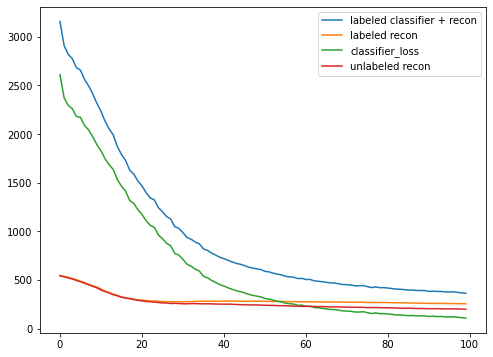

In [12]:
sample_size = 50
num_unlabeled = 100
rand_idx = np.random.choice(X_train.shape[0], size=sample_size+num_unlabeled, replace=False)
X_train_subset = X_train[rand_idx,:]
y_train_subset = y_train[rand_idx,:]


start = time.time()
print('Fitting with sample_size: {}'.format(sample_size))
if sample_size < len(X_train_subset):
    sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(X_train_subset), random_state=0)
    _, index = sss.split(X_train_subset, y_train_subset)
    X_lab, y_lab = X_train_subset[index[1]], y_train_subset[index[1]]
    X_others, _ = X_train_subset[index[0]], y_train_subset[index[0]]
else:
    X_lab, y_lab = X_train_subset, y_train_subset





ss_vae_lab.set_weights(ss_vae_lab_init_wts)
ss_vae_unlab.set_weights(ss_vae_unlab_init_wts)
classifier.set_weights(classifier_init_wts)

history = fit_model(X_others, X_lab, y_lab, epochs=100)


y_pred = np.argmax(classifier.predict(X_test, batch_size=batch_size), axis=-1)
score = accuracy_score(Y_test, y_pred)

end = time.time()
elapsed = end - start
print(' * Accuracy: %.1f %%' % (100. * score))
print(' * Fit time elapsed: %.1fs' % elapsed)

results = []
results.append({'sample_size': sample_size, 'accuracy': score, 'time': elapsed})

df = pd.DataFrame(history, columns=['labeled classifier + recon', 'labeled recon', 'classifier_loss', 'unlabeled recon'])
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

Now lets train with 100 labeled and 500 unlabeled samples.
We expect improvement in performance, since the representation of the samples (z) should be more accurate.*italicized text*

Fitting with sample_size: 50


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Elapsed:  0.7244021892547607
 * Accuracy: 49.1 %
 * Fit time elapsed: 1.0s


,labeled_loss,labeled_loss2,classifier_loss,unlabeled_loss
count,50.000000,50.000000,50.000000,50.000000
mean,1207.850098,330.635742,877.214294,306.272491
std,804.947388,86.443459,723.713379,95.528389
min,459.004639,273.205078,185.799545,235.953705
0%,459.004639,273.205078,185.799545,235.953705
25%,572.478775,283.233231,289.245522,249.502102
50%,834.910187,286.354355,548.489380,258.548203
75%,1656.993866,314.814980,1342.178894,299.308914
95%,2794.991345,533.500046,2261.491394,528.197833
99%,3029.523384,544.510327,2485.013025,542.197427


<AxesSubplot:>

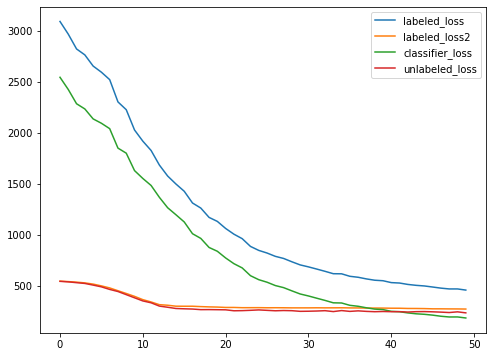

In [13]:
sample_size = 50
num_unlabeled = 500
rand_idx = np.random.choice(X_train.shape[0], size=sample_size+num_unlabeled, replace=False)
X_train_subset = X_train[rand_idx,:]
y_train_subset = y_train[rand_idx,:]


start = time.time()
print('Fitting with sample_size: {}'.format(sample_size))
if sample_size < len(X_train_subset):
    sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(X_train_subset), random_state=0)
    _, index = sss.split(X_train_subset, y_train_subset)
    X_lab, y_lab = X_train_subset[index[1]], y_train_subset[index[1]]
    X_others, _ = X_train_subset[index[0]], y_train_subset[index[0]]
else:
    X_lab, y_lab = X_train_subset, y_train_subset



ss_vae_lab.set_weights(ss_vae_lab_init_wts)
ss_vae_unlab.set_weights(ss_vae_unlab_init_wts)
classifier.set_weights(classifier_init_wts)

history = fit_model(X_others, X_lab, y_lab, epochs=n_epoch)


y_pred = np.argmax(classifier.predict(X_test, batch_size=batch_size), axis=-1)
score = accuracy_score(Y_test, y_pred)

end = time.time()
elapsed = end - start
print(' * Accuracy: %.1f %%' % (100. * score))
print(' * Fit time elapsed: %.1fs' % elapsed)

results = []
results.append({'sample_size': sample_size, 'accuracy': score, 'time': elapsed})

df = pd.DataFrame(history, columns=['labeled_loss', 'labeled_loss2', 'classifier_loss', 'unlabeled_loss'])
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

Now lets train with 100 labeled and 5000 unlabeled samples.
We expect *more* improvement in performance, since the representation of the samples (z) should be more accurate.
The more data we use (even though it is unlabeled) should improve the end classifier.

Fitting with sample_size: 50


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Elapsed:  6.379716396331787
 * Accuracy: 54.8 %
 * Fit time elapsed: 6.6s


,labeled_loss,labeled_loss2,classifier_loss,unlabeled_loss
count,500.000000,500.000000,500.000000,500.000000
mean,332.096436,202.131409,129.965042,199.134857
std,385.812805,60.689217,332.303070,52.661568
min,166.248505,144.573807,20.282906,153.363815
0%,166.248505,144.573807,20.282906,153.363815
25%,188.611210,160.279701,27.987180,171.165230
50%,224.094360,184.534424,38.825880,183.700272
75%,294.618118,227.728313,67.425154,209.023064
95%,839.645502,277.151009,564.628589,258.578963
99%,2586.643179,505.266303,2081.266594,497.191499


<AxesSubplot:>

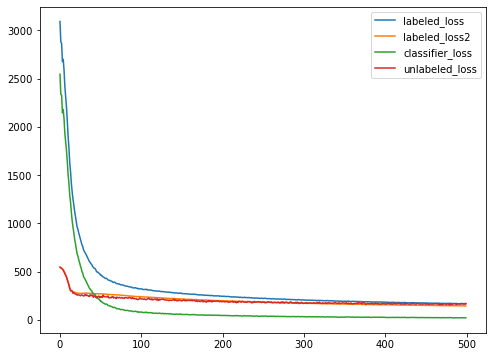

In [14]:
sample_size = 50
num_unlabeled = 5000
rand_idx = np.random.choice(X_train.shape[0], size=sample_size+num_unlabeled, replace=False)
X_train_subset = X_train[rand_idx,:]
y_train_subset = y_train[rand_idx,:]


start = time.time()
print('Fitting with sample_size: {}'.format(sample_size))
if sample_size < len(X_train_subset):
    sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(X_train_subset), random_state=0)
    _, index = sss.split(X_train_subset, y_train_subset)
    X_lab, y_lab = X_train_subset[index[1]], y_train_subset[index[1]]
    X_others, _ = X_train_subset[index[0]], y_train_subset[index[0]]
else:
    X_lab, y_lab = X_train_subset, y_train_subset


ss_vae_lab.set_weights(ss_vae_lab_init_wts)
ss_vae_unlab.set_weights(ss_vae_unlab_init_wts)
classifier.set_weights(classifier_init_wts)

history = fit_model(X_others, X_lab, y_lab, epochs=n_epoch)


y_pred = np.argmax(classifier.predict(X_test, batch_size=batch_size), axis=-1)
score = accuracy_score(Y_test, y_pred)

end = time.time()
elapsed = end - start
print(' * Accuracy: %.1f %%' % (100. * score))
print(' * Fit time elapsed: %.1fs' % elapsed)

results = []
results.append({'sample_size': sample_size, 'accuracy': score, 'time': elapsed})

df = pd.DataFrame(history, columns=['labeled_loss', 'labeled_loss2', 'classifier_loss', 'unlabeled_loss'])
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

# **Baseline Model**

To ensure that we are beating the baseline model, lets use the same amount if labeled data to see that we will not perform as well.

In [15]:
# baseline classifier

# normalizing the data to make the neural ntwork easier to learn
x_train = normalize(X_train, axis=1)
x_test = normalize(X_test, axis=1)

#choosing the sequential model
baseline_model = Sequential()

# defining the architecture of the model
# this has a similar number of parameters 
# but is still a good comparator
X_class = Input(shape=(n_x,))
baseline_model.add(X_class)
baseline_model.add(Dense(512, activation='relu'))
baseline_model.add(Dense(10, activation='softmax'))

#defining the parameters to train the model
baseline_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
baseline_model.summary()

sample_size = 50
rand_idx = np.random.choice(X_train.shape[0], size=sample_size, replace=False)
X_train_subset = X_train[rand_idx,:]
y_train_subset = y_train[rand_idx,:]

#training the model
baseline_model.fit(X_train_subset, y_train_subset, epochs=n_epoch)

# get accuracy
y_pred = np.argmax(baseline_model.predict(X_test, batch_size=batch_size), axis=-1)
score = accuracy_score(Y_test, y_pred)

print(' * Accuracy: %.1f %%' % (100. * score))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Train on 50 samples
Epoch 1/10
50/50 [==============================] - 0s 1ms/sample - loss: 2.3688 - accuracy: 0.1000
Epoch 2/10
50/50 [==============================] - 0s 96us/sample - loss: 1.6690 - accuracy: 0.4200
Epoch 3/10
50/50 [==============================] - 0s 91us/sample - loss: 1.2790 - accuracy: 0.6800
Epoch 4/10
50/50 [==============================] - 0s 83us/sample - loss: 0.9879 - accuracy: 0.7600
Epoch 5/10
50/50 [=====